In [1]:
# Import libraries
## for profiling
from profiler.main import profile

# for titiler-xarray
from typing import Any
from titiler.xarray.factory import xarray_open_dataset, update_dataset
import morecantile
from rio_tiler.io import XarrayReader

# for titiler-pgstac
from titiler.pgstac.mosaic import PGSTACBackend
from typing import Any, Dict, List, Tuple
from rio_tiler.mosaic import mosaic_reader
from rio_tiler.models import ImageData
from geojson_pydantic import Polygon

# Only if wanting to see a picture
import io
from PIL import Image

In [2]:
search_dict: Dict[str, Any] = {
    'collections': ["CMIP6_ensemble_median_TAS"],
    'datetime': "1951-01-01T00:00:00Z",
    'bbox': [-180, -90, 180, 90]
}

xyz_tile = (0,0,0)

## Profile titiler-xarray

In [5]:
@profile(add_to_return=True, cprofile=True, quiet=True, log_library='s3fs')
def tile(src_path: str, x: int, y: int, z: int, *, variable: str, time_slice: str = None, **kwargs: Any):

    with xarray_open_dataset(
        src_path,
        z=z,
        decode_times=False,
        **kwargs,
    ) as dataset:
        dataarray, _ = update_dataset(dataset, variable=variable, time_slice=time_slice)
        
        with XarrayReader(dataarray) as src_dst:
            return src_dst.tile(x, y, z)

In [6]:
image_and_assets, logs = tile(
    "titiler-xarray/combined_cmip6_kerchunk.json", 
    *xyz_tile,
    time_slice = search_dict['datetime'],
    reference=True,
    variable="tas",
)
logs

Opening reference file


/Users/aimeebarciauskas/miniconda3/lib/python3.9/site-packages/titiler/xarray/factory.py:50: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  return xarray.open_dataset(src_path, **xr_open_args)
/Users/aimeebarciauskas/miniconda3/lib/python3.9/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(


Setting up s3fs instance
RC: caching enabled? False (explicit option is False)
CALL: get_object - () - {'Bucket': 'climatedashboard-data', 'Key': 'cmip6/raw/monthly/CMIP6_ensemble_median/tas/tas_month_ensemble-median_historical_1950.nc', 'Range': 'bytes=21990-26789'}
CALL: get_object - () - {'Bucket': 'climatedashboard-data', 'Key': 'cmip6/raw/monthly/CMIP6_ensemble_median/tas/tas_month_ensemble-median_historical_1950.nc', 'Range': 'bytes=10470-21989'}
CALL: get_object - () - {'Bucket': 'climatedashboard-data', 'Key': 'cmip6/raw/monthly/CMIP6_ensemble_median/tas/tas_month_ensemble-median_historical_1950.nc', 'Range': 'bytes=45897-755594'}


{'cprofile': ['   ncalls  tottime  percall  cumtime  percall filename:lineno(function)',
  "       79    1.525    0.019    1.525    0.019 {method 'acquire' of '_thread.lock' objects}",
  '        1    0.028    0.028    0.029    0.029 {rasterio._warp._reproject}',
  '        4    0.011    0.003    0.024    0.006 core.py:1865(_process_chunk)',
  '        1    0.009    0.009    0.009    0.009 {built-in method zlib.decompress}',
  '        9    0.006    0.001    0.006    0.001 crs.py:161(__init__)',
  '        6    0.006    0.001    0.006    0.001 crs.py:964(geodetic_crs)',
  "        2    0.004    0.002    0.005    0.002 {method 'start' of 'rasterio._env.GDALEnv' objects}",
  '        1    0.004    0.004    0.004    0.004 {built-in method numcodecs._shuffle._doUnshuffle}',
  '        2    0.004    0.002    0.004    0.002 {rasterio._warp._transform_bounds}',
  '10365/9985    0.002    0.000    0.004    0.000 {built-in method builtins.isinstance}',
  "       25    0.002    0.000    0.002    

/Users/aimeebarciauskas/miniconda3/lib/python3.9/site-packages/rio_tiler/models.py:648: InvalidDatatypeWarning: Invalid type: `float32` for the `PNG` driver. Data will be rescaled using min/max type bounds or dataset_statistics.
  warnings.warn(


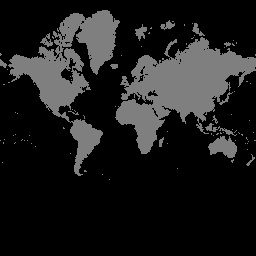

In [7]:
content = image_and_assets.render(
    img_format='PNG'
)

im = Image.open(io.BytesIO(content))
im

## Profile titiler-pgstac

In [8]:
import tile_pgstac

@profile(add_to_return=True, cprofile=True, quiet=True, log_library = 'rasterio')
def tile(
    tile_x: int,
    tile_y: int,
    tile_z: int,
) -> Tuple[ImageData, List[str]]:
    
    pool = tile_pgstac.connection_pool()
    backend = PGSTACBackend(pool=pool, input=tile_pgstac.mosaic_id(search_dict=search_dict, pool=pool))
    bbox = backend.tms.bounds(morecantile.Tile(tile_x, tile_y, tile_z))
    mosaic_assets = backend.get_assets(Polygon.from_bounds(*bbox))    

    def _reader(
        item: Dict[str, Any], x: int, y: int, z: int, **kwargs: Any
    ) -> ImageData:
        with backend.reader(item, tms=backend.tms, **backend.reader_options) as src_dst:
            return src_dst.tile(x, y, z, **kwargs)

    return mosaic_reader(mosaic_assets, _reader, tile_x, tile_y, tile_z, threads=10, **{"assets": ["data"]})  

In [9]:
image_and_assets, logs = tile(*xyz_tile)
logs

Matched. confidence=100, c_code=b'3857', c_name=b'EPSG'
Entering env context: <rasterio.env.Env object at 0x148e58ee0>
Starting outermost env
No GDAL environment exists
New GDAL environment <rasterio._env.GDALEnv object at 0x148e58fa0> created
GDAL_DATA found in environment.
PROJ_LIB found in environment.
Started GDALEnv: self=<rasterio._env.GDALEnv object at 0x148e58fa0>.
Entered env context: <rasterio.env.Env object at 0x148e58ee0>
Got a copy of environment <rasterio._env.GDALEnv object at 0x148e58fa0> options
Entering env context: <rasterio.env.Env object at 0x148f09370>
Got a copy of environment <rasterio._env.GDALEnv object at 0x148e58fa0> options
Entered env context: <rasterio.env.Env object at 0x148f09370>
Sharing flag: 0
Nodata success: 1, Nodata value: nan
Dataset <open DatasetReader name='s3://climatedashboard-data/cmip6/monthly/CMIP6_ensemble_median/tas/tas_month_ensemble-median_historical_195101.tif' mode='r'> is started.
Exiting env context: <rasterio.env.Env object at 0x1

{'cprofile': ['   ncalls  tottime  percall  cumtime  percall filename:lineno(function)',
  "       36    4.379    0.122    4.379    0.122 {method 'acquire' of '_thread.lock' objects}",
  "       18    0.086    0.005    0.086    0.005 {method 'control' of 'select.kqueue' objects}",
  '        8    0.002    0.000    0.002    0.000 connection.py:410(_exec_command)',
  '        2    0.001    0.000    0.001    0.000 core.py:3435(__setmask__)',
  '        1    0.001    0.001    4.474    4.474 3069477002.py:3(tile)']}

/Users/aimeebarciauskas/miniconda3/lib/python3.9/site-packages/rio_tiler/models.py:648: InvalidDatatypeWarning: Invalid type: `float64` for the `PNG` driver. Data will be rescaled using min/max type bounds or dataset_statistics.
  warnings.warn(


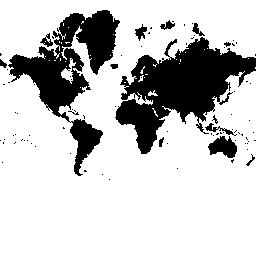

In [11]:
content = image_and_assets[0].render(
    img_format='PNG'
)

im = Image.open(io.BytesIO(content))
im